In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [6]:
import os


In [7]:
pneum_path="Pneumonia/Пневмония"
tub_path="Tuberculosis/Туберкулез"
can_path="Cancer/0"
print(pneum_path,tub_path,can_path)

Pneumonia/Пневмония Tuberculosis/Туберкулез Cancer/0


In [8]:
arrPneumPath=os.listdir(pneum_path)
arrTubPath=os.listdir(tub_path)
arrCanPath=os.listdir(can_path)

In [9]:
# функция вычисления путей до конктреного слоя кт
def addPath(path, arrPath):
    arr=[]
    for i in range(0, len(arrPath)):
        inDirectory=os.listdir(path+"/"+arrPath[i])
        new_path=path+"/"+arrPath[i]
        for j in range(0, len(inDirectory)):
            inPostDirectory=os.listdir(new_path+"/"+inDirectory[j]+"/")
            for k in range(0, len(inPostDirectory)):
                end_pneum_path=new_path+"/"+inDirectory[j]+"/"+inPostDirectory[k]
                inLastDir=os.listdir(end_pneum_path)
                for m in range(0, len(inLastDir)):
                    endDir=end_pneum_path+"/"+inLastDir[m]
                    arr.append(endDir)
    return arr
arrPneum=addPath(pneum_path, arrPneumPath)
arrTub=addPath(tub_path, arrTubPath)
arrCan=addPath(can_path, arrCanPath)

In [10]:
print("lenPneum: ", len(arrPneum), "\nlenTub: ", len(arrTub), "\nlenCan: ", len(arrCan))

lenPneum:  2001 
lenTub:  2515 
lenCan:  1558


In [11]:
!pip install pydicom
!pip install opencv-python
!pip install Pillow
!pip install numpy scipy scikit-learn

^C


In [8]:
!pip install scikeras


In [ ]:
!pip install np_utils

In [10]:
import numpy as np
import keras as kr
import tensorflow as tf


In [9]:
kr.__version__


'2.15.0'

In [11]:
tf.__version__


'2.15.0'

In [12]:
# импортируем необходимые библиотеки
import pydicom as dicom
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
# from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np


In [13]:
size=[]
# функция вычисления количества больных каждого типа болезни
def sizeCheked(arrPneum):
    pixel_array_numpy=[]
    for i in range(0, len(arrPneum)):
        try:
            image_path = arrPneum[i]
            ds = dicom.dcmread(image_path)
            pixel_array_numpy.append(ds.pixel_array)
        except FileNotFoundError:
            print(i, ": none")
    for i in range(0, len(pixel_array_numpy)):
        for j in range(0, len(pixel_array_numpy[i])):
            if(pixel_array_numpy[i][j].size!=512):
                print(pixel_array_numpy[i][j].size)

In [14]:
# функция форматирование путей для pandas
def spliting(arr):
    splitArray=[]
    for i in range(0,len(arr)):
        splitArray.append(arr[i].split('/'))
    return splitArray
spliter=spliting(arrPneum)+spliting(arrTub)+spliting(arrCan)

In [15]:
spliter

[['Pneumonia',
  'Пневмония',
  'AL191de18aa65dca99adfb0f0e8efab9ce',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537433.873448.dcm'],
 ['Pneumonia',
  'Пневмония',
  'AL191de18aa65dca99adfb0f0e8efab9ce',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537439.229630.dcm'],
 ['Pneumonia',
  'Пневмония',
  'AL191de18aa65dca99adfb0f0e8efab9ce',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537439.659323.dcm'],
 ['Pneumonia',
  'Пневмония',
  'AL191de18aa65dca99adfb0f0e8efab9ce',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871',
  '1.2.392.2

In [16]:
len(spliter)

6074

In [17]:
# созздаепм верный формат путей до КТ снимков для загрузки их в pandas
preCsv=[]
for i in range(0,len(spliter)):
    preCsv.append([spliter[i][0], spliter[i][3], "/".join(spliter[i])])

In [19]:
preCsv

[['Pneumonia',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  'Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e8efab9ce/1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311/1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871/1.2.392.200036.9116.2.6.1.48.1211466065.1282537433.873448.dcm'],
 ['Pneumonia',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  'Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e8efab9ce/1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311/1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871/1.2.392.200036.9116.2.6.1.48.1211466065.1282537439.229630.dcm'],
 ['Pneumonia',
  '1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311',
  'Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e8efab9ce/1.2.392.200036.9116.2.6.1.48.1211466065.1282536859.960311/1.2.392.200036.9116.2.6.1.48.1211466065.1282537411.816871/1.2.392.200036.9116.2.6.1.48.1211466065.1282537439.659323.dcm'],
 ['Pneumonia',
  '1.2.392.200036.9116.2.6.1.48.12

In [ ]:
!pip install pandas

In [18]:
import pandas as pd
df = pd.DataFrame(preCsv) # загружаем данные КТ снимоков в pandas
df.to_csv('file.csv', index=False, header=True) # сохраняем в файл

In [19]:
# назначем названия колонок и раскрываем содержимое датафрейма:
df.columns = ['Type', 'img_name', 'path_to_img']
df

,Type,img_name,path_to_img
0,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...
1,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...
2,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...
3,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...
4,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...
...,...,...,...
6069,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....
6070,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....
6071,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....
6072,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....


In [20]:
import numpy as np
# функция преобразования в хаумсфилдские юниты снимка КТ
def get_pixels_hu(scans):
    image = np.stack([scans.pixel_array])#np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16),
    # возможно, так как значения всегда должны быть достаточно низкими (<32k)
    image = image.astype(np.int16)

    # Установит значение пикселов вне области сканирования равным 1
    # intercept обычно составляет -1024, так что воздух составляет примерно 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    intercept = scans.RescaleIntercept
    slope = scans.RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    return np.array(image, dtype=np.int16)

In [21]:
from skimage.transform import resize

In [22]:
# Обертачная функция для финкции преобразования в хаумсфилдские юниты снимка КТ
def get_pixel_uid(x):
    try:
        dcm_x=dicom.dcmread(x, force=True)
        #dcm_x.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
        return dcm_x.pixel_array; 
        # return get_pixels_hu(dcm_x).flatten()
    except AttributeError:
        return None

In [23]:
import tensorflow as tf

In [24]:
# преорбразуем каждый DICOM снимок в хаумсфилдские юниты
with tf.device('/GPU:0'):
        df["img"]=df["path_to_img"].apply(lambda x: get_pixel_uid(x))

PermissionError: [Errno 13] Permission denied: 'Pneumonia/Пневмония/ELe66728d9ce91680a8a6a3fddba3c2046/CHe735abab8b77b483e365c570aac4dcf0/1.2.392.200036.9116.2.6.1.48.1211466065.1311154075.770494/1.2.392.200036.9116.2.6.1.48.1211466065.1311154626.597993'

In [28]:
df

,Type,img_name,path_to_img,img
0,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
1,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
2,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
3,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
4,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
...,...,...,...,...
6166,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
6167,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
6168,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."
6169,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2..."


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader


In [30]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        # 256 -> 128
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        # 128 -> 64
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        # 64 -> 32
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True))

        # 32 -> 16
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                       kernel_size=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=256,
                                                       kernel_size=3, padding=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=512,
                                                       kernel_size=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))

        # decoder (upsampling)

        # 16 -> 32
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        # 32 -> 64
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        # 64 -> 128
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        # 128 -> 256
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=1,
                                                kernel_size=3, padding=1, stride=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))
        return d3

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# функция дублирования одного слоя на 3
def expand_greyscale_image_channels(grey_pil_image):
    grey_image_arr = np.array(grey_pil_image)
    grey_image_arr = np.expand_dims(grey_image_arr, -1)
    grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=-1)
    return grey_image_arr_3_channel

In [33]:
def predict_model_s(model, data):
    Y_pred=0
    predict = 0
    for X_batch , y in data:
        Y_pred = model(X_batch.to(device))

    return Y_pred

In [34]:
u=torch.load('weigth',map_location=torch.device('cpu'))
model = UNet().to(device)
model.load_state_dict(u)
model.eval()

UNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [35]:
mockTest = []
mockTest.append(np.zeros((256,256)))
mockY = np.array(mockTest)
mockY = mockY[0,np.newaxis]

In [36]:
mockY.shape

(1, 256, 256)

In [37]:
#Standardize the pixel values
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure


def make_lungmask(img):
    resizedDicom = resize(img, (256,256 ))
    resizedDicom = np.array(resizedDicom, np.float32)
    resizedImg = (np.maximum(resizedDicom, 0) / resizedDicom.max()) * 255.0
    resizedImg = np.array(np.uint8(resizedImg), np.float32)
    d_ret, d_bw_img = cv2.threshold(resizedImg, 0.1, 1, cv2.THRESH_BINARY)
    d_bw_img = expand_greyscale_image_channels(d_bw_img)
    test= []
    test.append(d_bw_img)
    d_bw_img_s = np.array(test, np.float32)
    f = list(zip(np.rollaxis(d_bw_img_s, 3, 1),mockY[0, np.newaxis]))
    data_img = DataLoader(f, batch_size=8, shuffle=True)
    pred_u = predict_model_s(model, data_img)
    resultImg = pred_u[0].detach().cpu().reshape(256,256)


    count = 0
    sum = 0
    for x in range(0, len(resultImg)):
        for y in range(0, len(resultImg[0])):
            if(resultImg[x,y] > 0):
                sum += resizedDicom[x,y]
                count += 1
    
    normalaizedValue = 1
    if(sum != 0 or count != 0):
        normalaizedValue = sum / count  

    for x in range(0, len(resizedDicom)):
        for y in range(0, len(resizedDicom[0])):
            resizedDicom[x,y] /= normalaizedValue
    return expand_greyscale_image_channels(resizedDicom)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)

    return image, new_spacing


In [38]:
df.columns = ['Type', 'img_name', 'path_to_img']

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

In [39]:
import matplotlib.pylab as plt

In [40]:
# функция получения необходимого преобразованнго слоя
def aply_mask(img):
    return make_lungmask(img)

In [41]:
# преобразование данных
df["mask"]=df["img"].apply(lambda x:aply_mask(x))

In [42]:
# избавление от дубликатов
dx = df.sample(frac=1).reset_index(drop=True)

In [40]:
df

,Type,img_name,path_to_img,img,mask
0,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
1,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
2,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
3,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
4,Pneumonia,1.2.392.200036.9116.2.6.1.48.1211466065.128253...,Pneumonia/Пневмония/AL191de18aa65dca99adfb0f0e...,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
...,...,...,...,...,...
6166,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
6167,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
6168,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."
6169,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.153111...,Cancer/0/LU6970bea251b7736693519b952a20b569/1....,"[[-2048, -2048, -2048, -2048, -2048, -2048, -2...","[[[-0.06250191, -0.06250191, -0.06250191], [-0..."


In [43]:
df.to_csv('save3.csv', index=False, header=True) # сохраняем в файл

In [67]:
df.to_csv('save2.csv', index=True, header=True) # сохраняем в файл

In [43]:
dx.isnull().sum()

Type           0
img_name       0
path_to_img    0
img            0
mask           0
dtype: int64

In [44]:
dx=dx[dx['img'].notna()]
dx.isnull().sum()

Type           0
img_name       0
path_to_img    0
img            0
mask           0
dtype: int64

In [45]:
# удаление не нужных столбцов
del dx['img']
del dx['path_to_img']
del dx['img_name']

In [44]:
print(dx)

              Type                                               mask
0     Tuberculosis  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
1           Cancer  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
2     Tuberculosis  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
3           Cancer  [[[-0.06103702, -0.06103702, -0.06103702], [-0...
4     Tuberculosis  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
...            ...                                                ...
6166  Tuberculosis  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
6167        Cancer  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
6168        Cancer  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
6169  Tuberculosis  [[[-0.06250191, -0.06250191, -0.06250191], [-0...
6170  Tuberculosis  [[[-0.06250191, -0.06250191, -0.06250191], [-0...

[6171 rows x 2 columns]


In [46]:
Xc = dx['mask'] # преобразованные изображения
Yc = dx['Type'] # болезнь пациента
# создаем обЪект с мультиклассовыми метками
encoder = LabelEncoder()
encoder.fit(Yc)


LabelEncoder()

In [10]:
!pip list -v

Package                      Version     Location                                                      Installer
---------------------------- ----------- ------------------------------------------------------------- ---------
absl-py                      2.1.0       C:\Users\akimo\anaconda3\envs\mag\Lib\site-packages           pip
asttokens                    2.2.1       C:\Users\akimo\AppData\Roaming\Python\Python311\site-packages pip
astunparse                   1.6.3       C:\Users\akimo\anaconda3\envs\mag\Lib\site-packages           pip
backcall                     0.2.0       C:\Users\akimo\AppData\Roaming\Python\Python311\site-packages pip
cachetools                   5.3.3       C:\Users\akimo\anaconda3\envs\mag\Lib\site-packages           pip
certifi                      2024.2.2    C:\Users\akimo\anaconda3\envs\mag\Lib\site-packages           pip
charset-normalizer           3.3.2       C:\Users\akimo\anaconda3\envs\mag\Lib\site-packages           pip
colorama                 

In [66]:
Yc

array(['Pneumonia', 'Cancer', 'Cancer', ..., 'Cancer', 'Tuberculosis',
       'Tuberculosis'], dtype=object)

In [47]:
# пропускаем изображение исколючение
Xc=np.concatenate((Xc[0:107],Xc[108:len(Xc)]))
Yc=np.concatenate((Yc[0:107],Yc[108:len(Yc)]))

In [48]:
from sklearn.utils import shuffle
Xz, yz = shuffle(Xc, Yc, random_state=0)

In [67]:
yz

array(['Pneumonia', 'Tuberculosis', 'Cancer', ..., 'Pneumonia',
       'Tuberculosis', 'Cancer'], dtype=object)

In [50]:
from keras.src.utils.np_utils import to_categorical


In [51]:
# преобразуем стобец с болезнью в мультукласовый
encoded_Yc = encoder.transform(yz)
dummy_y = to_categorical(encoded_Yc)

In [52]:
dummy_y

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [53]:
#преобразование Python List в numpyNdArray
new_X=[]
for i in range(0,len(Xz)):
    new_X.append(Xz[i])
new_X=np.array(new_X)
new_X.shape

(6170, 256, 256, 3)

**RESNET**

In [54]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from sklearn.datasets import load_files
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


In [55]:
from tensorflow.keras.applications.resnet50 import ResNet50 # импортируем готовую модель ResNet50

In [68]:
img_height,img_width = 256,256 # размер одного изображения
num_classes = 3 # количество классов
#создаем модель исключаем первый уровень свертки  и с размером изображении 64 на 64
base_model = ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [69]:
# создаем полносвязанную сеть для классификатора
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [70]:
from tensorflow.keras.optimizers import SGD, Adam
#добавлеем оптимизаторы и функцию потерь
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
#создаем конфигурацию хода обучения сети
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 50
EPOCHS = 10


In [90]:
# обучаем модель
history = model.fit(new_X[0:5200], dummy_y[0:5200], batch_size=BATCH_SIZE,validation_data=(new_X[5200:5934], dummy_y[5200:5934]), epochs=EPOCHS)


MemoryError: Unable to allocate 3.81 GiB for an array with shape (5200, 256, 256, 3) and data type float32

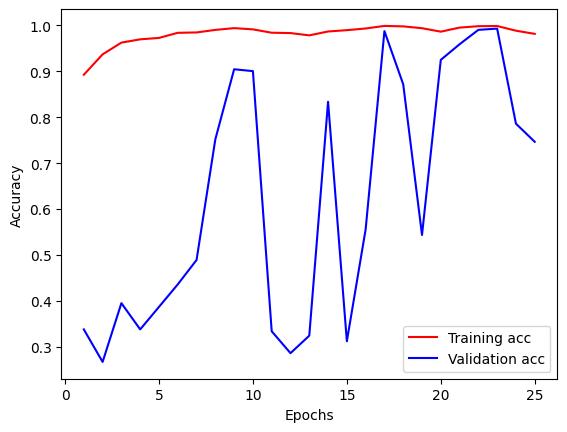

In [73]:
#выводим график хода обучения
import matplotlib.pyplot as plt
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
# вычисляем f1 метрику для тестовой выборки
from sklearn.metrics import f1_score
pred = model.predict(new_X[5934:6000])
trues = dummy_y[5934:6000]
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

3/3 [==============================] - 5s 618ms/step


array([0.75      , 0.86956522, 0.68421053])

In [75]:
from sklearn.metrics import accuracy_score
pred = model.predict(new_X[5934:6000])
trues = dummy_y[5934:6000]
accuracy_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1))

3/3 [==============================] - 2s 598ms/step


0.7727272727272727

In [77]:
model.save_weights('my_checkpoint')


**VGG16**

In [56]:
# Конфигурируем процесс обучения нейросети
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 50
EPOCHS = 18

In [57]:
# импортируем все необходимые библиотеки
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16 # импортируем VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
num_classes = 3 # количество классов
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG


# создаем полносвязанную сеть для классификатора
x = Flatten()(vgg.output)
x = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = x)
#добавлеем оптимизаторыы и функцию потерь
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
# Обучаем модель
history = model.fit(new_X[0:5200], dummy_y[0:5200], batch_size=BATCH_SIZE,validation_data=(new_X[5200:5934], dummy_y[5200:5934]), epochs=EPOCHS)


Epoch 1/18
104/104 [==============================] - 1271s 12s/step - loss: 1.1110 - accuracy: 0.4025 - val_loss: 1.0740 - val_accuracy: 0.4169
Epoch 2/18
104/104 [==============================] - 1257s 12s/step - loss: 1.0956 - accuracy: 0.4063 - val_loss: 1.0746 - val_accuracy: 0.4169
Epoch 3/18
104/104 [==============================] - 1282s 12s/step - loss: 1.0817 - accuracy: 0.4073 - val_loss: 1.0719 - val_accuracy: 0.4169
Epoch 4/18
104/104 [==============================] - 1278s 12s/step - loss: 1.0814 - accuracy: 0.4073 - val_loss: 1.0721 - val_accuracy: 0.4169
Epoch 5/18
104/104 [==============================] - 1278s 12s/step - loss: 1.0812 - accuracy: 0.4073 - val_loss: 1.0740 - val_accuracy: 0.4169
Epoch 6/18
104/104 [==============================] - 1253s 12s/step - loss: 1.0819 - accuracy: 0.4073 - val_loss: 1.0732 - val_accuracy: 0.4169
Epoch 7/18
104/104 [==============================] - 1245s 12s/step - loss: 1.0815 - accuracy: 0.4073 - val_loss: 1.0728 - val_ac

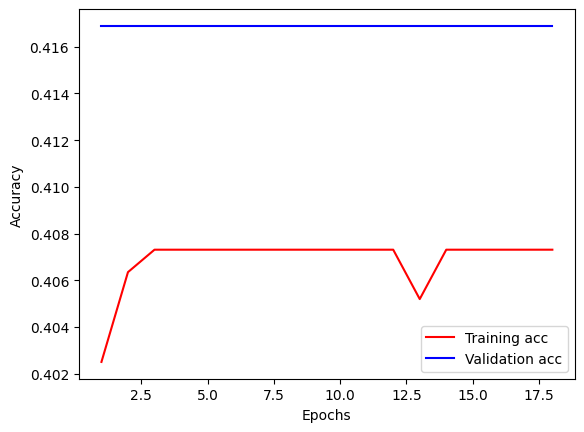

In [60]:
# Создаем график процесса обучения
import matplotlib.pyplot as plt
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [64]:
# вычисляем f1 метрику для тестовой выборки
from sklearn.metrics import f1_score
pred = model.predict(new_X[5934:6000])
trues = dummy_y[5934:6000]
print('f1 score for test sample')
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

3/3 [==============================] - 6s 2s/step
f1 score for test sample


array([0. , 0. , 0.5])

In [65]:
from sklearn.metrics import accuracy_score
pred = model.predict(new_X[5934:6000])
trues = dummy_y[5934:6000]
accuracy_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1))

3/3 [==============================] - 6s 1s/step


0.3333333333333333

In [73]:
history = model.fit(new_X[0:5200], dummy_y[0:5200], batch_size=BATCH_SIZE,validation_data=(new_X[5200:5934], dummy_y[5200:5934]), epochs=9)


Epoch 1/9
104/104 [==============================] - 550s 5s/step - loss: 0.0537 - accuracy: 0.9813 - val_loss: 6.7416 - val_accuracy: 0.5395
Epoch 2/9
104/104 [==============================] - 514s 5s/step - loss: 0.0375 - accuracy: 0.9873 - val_loss: 2.1658 - val_accuracy: 0.6948
Epoch 3/9
104/104 [==============================] - 513s 5s/step - loss: 0.0338 - accuracy: 0.9879 - val_loss: 0.3625 - val_accuracy: 0.8910
Epoch 4/9
104/104 [==============================] - 504s 5s/step - loss: 0.0167 - accuracy: 0.9925 - val_loss: 1.6060 - val_accuracy: 0.7384
Epoch 5/9
104/104 [==============================] - 503s 5s/step - loss: 0.0652 - accuracy: 0.9812 - val_loss: 6.8118 - val_accuracy: 0.4946
Epoch 6/9
104/104 [==============================] - 505s 5s/step - loss: 0.0352 - accuracy: 0.9873 - val_loss: 5.8200 - val_accuracy: 0.2861
Epoch 7/9
104/104 [==============================] - 506s 5s/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 2.5147 - val_accuracy: 0.6649
Epoch 

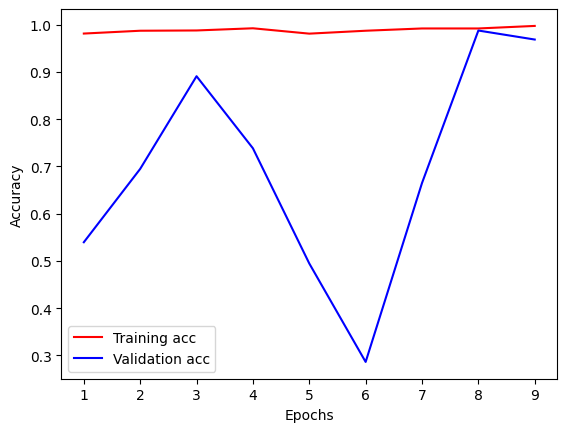

In [78]:
# Создаем график процесса обучения
import matplotlib.pyplot as plt
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
# вычисляем f1 метрику для тестовой выборки
from sklearn.metrics import f1_score
pred = model.predict(new_X[5934:6000])
trues = dummy_y[5934:6000]
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

3/3 [==============================] - 4s 594ms/step


array([1., 1., 1.])

In [75]:
from sklearn.metrics import accuracy_score
pred = model.predict(new_X[5934:6000])
trues = dummy_y[5934:6000]
accuracy_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1))

3/3 [==============================] - 2s 630ms/step


1.0

In [79]:
model.save_weights('my_checkpoint123')


**Использование предобученнорй сети**

In [ ]:
# model.save('/contentmy_model.h5')


In [ ]:
# загуржаем готовую сеть
new_model = tf.keras.models.load_model('my_model.h5')


In [ ]:
#f1 метрика на тестовой выборке
from sklearn.metrics import f1_score
pred = new_model.predict(new_X[4500:5934])
trues = dummy_y[4500:5934]
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

array([0.88709677, 0.82632541, 0.86655113])

In [ ]:
#accuracy метрика на обучающей выборке
loss, acc = new_model.evaluate(new_X[0:4500], dummy_y[0:4500], verbose=2)
print("Restored model, learning accuracy: {:5.2f}%".format(100 * acc))


141/141 - 2s - loss: 0.1552 - accuracy: 0.9136 - 2s/epoch - 17ms/step
Restored model, learning accuracy: 91.36%


In [ ]:
#accuracy метрика на тестовой выборке
loss, acc = new_model.evaluate(new_X[5400:5934], dummy_y[5400:5934], verbose=2)
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))


17/17 - 1s - loss: 2.0152 - accuracy: 0.8371 - 746ms/epoch - 44ms/step
Restored model, test accuracy: 83.71%


In [ ]:
#f1 метрика на валидационной выборке
loss, acc = new_model.evaluate(new_X[4500:5934], dummy_y[4500:5934], verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

45/45 - 1s - loss: 1.8091 - accuracy: 0.8556 - 801ms/epoch - 18ms/step
Restored model, validation accuracy: 85.56%
